In [1]:
import torch
import numpy as np
from src.datasets.uci_loader import UCIDataset
import seaborn as sns
from src.model_builder import build_model, compute_mnll, predict
from src.core.sampler import SGHMC_sampler
from torchviz import make_dot
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# setting PyTorch

from src.misc.settings import settings
device = settings.device
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Load regression UCI dataset

data_uci = UCIDataset(dataset_path='data/uci/boston.pth', static_split=True, seed=0)
N, D = data_uci.X_train.shape
print(f'X-train: {N, D}')

/home/adm_kconstantin/miniconda3/envs/bsgp_env/lib/python3.8/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
INFO:root:Loading dataset from data/uci/boston.pth


X-train: (401, 13)


How the model works in BGSP:
1. There is a `run_regression.py` file to setup the model classes such as `RegressionModel` and the cmd line arguments
2. The `RegressionModel` in `models.py` builds the `DGP` model and launches a training loop with the hmc sampling inside
3. The `DGP` class is defined throug different `Layers` and instantiates the TensorFlow session and does the initialization 

In [2]:
#  Instantiate a model
class ARGS():
    num_inducing = 100
    n_layers = 1
    minibatch_size = 100
    window_size = 64
    output_dim= 1
    adam_lr = 0.01
    prior_inducing_type = "uniform"
    full_cov = False
    epsilon = 0.01
    mdecay = 0.05
    iterations = 512
    num_posterior_samples = 100
    posterior_sample_spacing = 32
    mcmc_measures = True
args = ARGS()

bsgp_model = build_model(data_uci.X_train, data_uci.Y_train, args)
if args.mcmc_measures:
    samples_ms_iter = np.empty((data_uci.X_test.shape[0], args.iterations))
    samples_vs_iter = np.empty((data_uci.X_test.shape[0], args.iterations))
    samples_logps_iter = np.empty((data_uci.X_test.shape[0], args.iterations))
#make_dot(nll, params={'nll': nll}).render("computation_graph", format="png", cleanup=True)

In [4]:
bsgp_model.reset(data_uci.X_train, data_uci.Y_train)
sghmc_sampler = SGHMC_sampler(bsgp_model.parameters(), N, args.mdecay, args.epsilon)
bsgp_model.zero_grad()
global_step = 0
for it in range(args.iterations):
    bsgp_model.sghmc_step(sghmc_sampler)
    global_step += 1

    if args.mcmc_measures:
        ms, vs = bsgp_model.predict_y(data_uci.X_test, len(bsgp_model.window), posterior=False)
        m = np.average(ms, 0)
        v = np.average(vs + ms**2, 0) - m**2
        samples_ms_iter[:,it:it+1] = ms[0]
        samples_vs_iter[:,it:it+1] = vs[0]
    
    if it % 50 == 1:
        marginal_ll = bsgp_model.print_sample_performance()
        print('TRAIN | iter = %6d      sample marginal LL = %5.2f' % (it, marginal_ll))
    
#bsgp_model.collect_samples(sghmc_sampler, args.num_posterior_samples, args.posterior_sample_spacing)

#ms, vs = predict(bsgp_model, data_uci.X_test, args.num_posterior_samples)
#mnll = compute_mnll(ms, vs, data_uci.Y_test, num_posterior_samples=args.num_posterior_samples, ystd=data_uci.Y_train_std).mean().tolist()
#print(f'Test MNLL = {mnll}')

TRAIN | iter =      1      sample marginal LL = -1.35
TRAIN | iter =     51      sample marginal LL = -1.46
TRAIN | iter =    101      sample marginal LL = -2.05
TRAIN | iter =    151      sample marginal LL = -8.01
TRAIN | iter =    201      sample marginal LL = -6.89
TRAIN | iter =    251      sample marginal LL = -7.21
TRAIN | iter =    301      sample marginal LL = -4.72
TRAIN | iter =    351      sample marginal LL = -3.48
TRAIN | iter =    401      sample marginal LL = -3.47
TRAIN | iter =    451      sample marginal LL = -3.26
TRAIN | iter =    501      sample marginal LL = -3.01


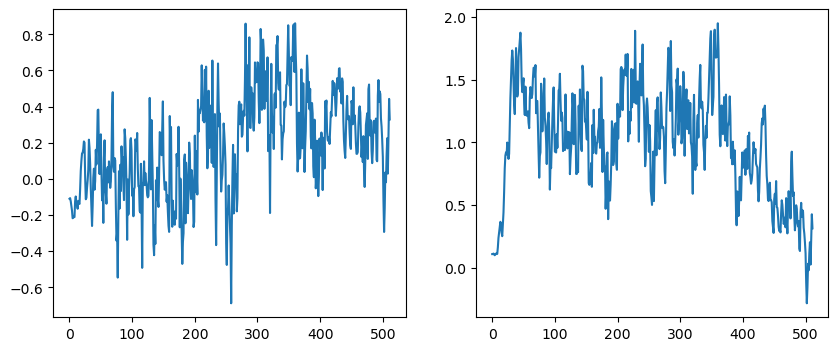

In [5]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
sns.lineplot(x=np.arange(args.iterations), y=samples_ms_iter[1], ax=axs[0])
sns.lineplot(x=np.arange(args.iterations), y=samples_ms_iter[2], ax=axs[1])
plt.show()

<Axes: ylabel='Density'>

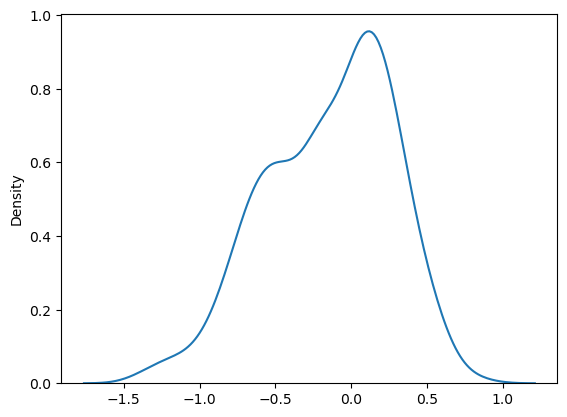

In [6]:
sns.kdeplot(x=samples_ms_iter[5])

Test MNLL = -4.223508734931791


<Axes: >

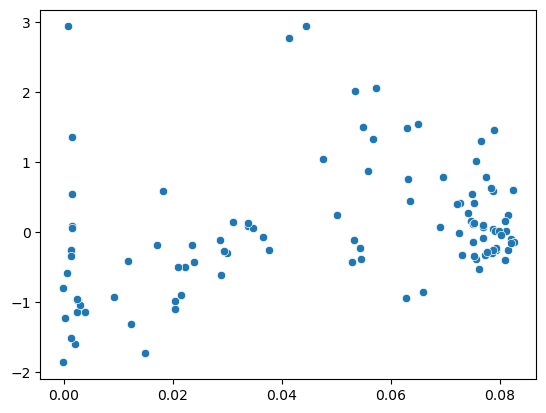

In [7]:
bsgp_model.collect_samples(sghmc_sampler, args.num_posterior_samples, args.posterior_sample_spacing)

ms, vs = predict(bsgp_model, data_uci.X_test, args.num_posterior_samples)
mnll = compute_mnll(ms, vs, data_uci.Y_test, num_posterior_samples=args.num_posterior_samples, ystd=data_uci.Y_train_std).mean().tolist()
print(f'Test MNLL = {mnll}')
m = np.average(ms, 0)
v = np.average(vs + ms**2, 0) - m**2
sns.scatterplot(x=m.reshape(-1), y=data_uci.Y_test.reshape(-1))

<Axes: >

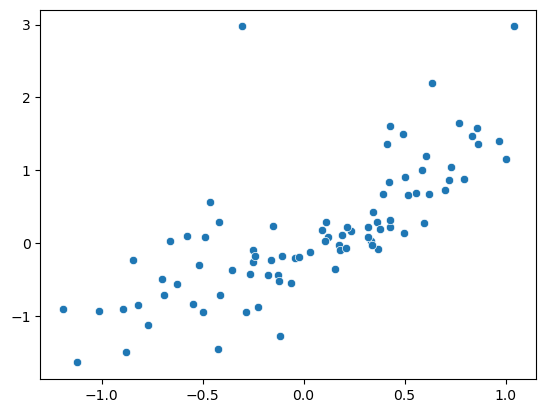

In [6]:
m = np.average(ms, 0)
v = np.average(vs + ms**2, 0) - m**2
sns.scatterplot(x=m.reshape(-1), y=data_uci.Y_test.reshape(-1))

In [11]:
bsgp_model.collect_samples(sghmc_sampler, args.num_posterior_samples, args.posterior_sample_spacing)

ms, vs = predict(bsgp_model, data_uci.X_test, args.num_posterior_samples)
mnll = compute_mnll(ms, vs, data_uci.Y_test, num_posterior_samples=args.num_posterior_samples, ystd=data_uci.Y_train_std).mean().tolist()
print(f'Test MNLL = {mnll}')

Test MNLL = -3.949727816826922


In [5]:
ms, vs = predict(bsgp_model, data_uci.X_test, args.num_posterior_samples)
mnll = compute_mnll(ms, vs, data_uci.Y_test, num_posterior_samples=args.num_posterior_samples, ystd=data_uci.Y_train_std).mean().tolist()
print(f'Test MNLL = {mnll}')

Test MNLL = -3.514273795408619


/home/adm_kconstantin/Desktop/BSGP_Project/BSGPtorch/src/core/bsgp.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  param.data.copy_(torch.tensor(value, dtype=torch.float64))
